In [46]:
import numpy as np
import matplotlib.pyplot as plt

import oqupy
import oqupy.operators as op

from scipy.optimize import minimize, Bounds
from typing import List,Tuple

# --- Parameters --------------------------------------------------------------

# -- time steps --
dt = 0.05 # 0.2
num_steps = 20 # 20

# -- bath --
alpha =  0.126 #0.08
omega_cutoff = 3.04 #4
temperature =  5 * 0.1309 #1.6
pt_dkmax =60 # 40
pt_epsrel = 10**(-7) #1.0e-5

# -- initial and target state --
initial_state = op.spin_dm('x-')
target_state = op.spin_dm('x+')

# -- initial parameter guess --
x0= np.zeros(2*num_steps)
z0 = np.ones(2*num_steps) * (np.pi) / (dt*num_steps)

parameter_list = list(zip(x0,z0))
num_params = len(parameter_list[0])

In [47]:
# --- Compute process tensors -------------------------------------------------
correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=3,
                                cutoff=omega_cutoff,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(oqupy.operators.sigma("z")/2, correlations)


pt_tempo_parameters = oqupy.TempoParameters(
    dt=dt,
    epsrel=pt_epsrel,
    dkmax=pt_dkmax)
process_tensor = oqupy.pt_tempo_compute(
    bath=bath,
    start_time=0.0,
    end_time=num_steps * dt,
    parameters=pt_tempo_parameters,
    progress_type='bar')

--> PT-TEMPO computation:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.3s


In [48]:
# --- Define parametrized system ----------------------------------------------

def get_hamiltonian_discrete():
    """
    Returns a callable which takes a set of parameters for a given time and returns the corresponding Hamiltonian

    """
    def hamiltonian(hx,hz):

        hx_sx = 0.5 * oqupy.operators.sigma('x') * hx
        hz_sz = 0.5 * oqupy.operators.sigma('z') * hz

        return hz_sz + hx_sx
    
    return hamiltonian

parametrized_system = oqupy.ParameterizedSystem(get_hamiltonian_discrete())

# --- Compute fidelity, dynamics, and fidelity gradient -----------------------

from oqupy.gradient import state_gradient

fidelity_dict = oqupy.state_gradient(
                system=parametrized_system,
                initial_state=initial_state,
                target_state=target_state,
                process_tensor=process_tensor,
                parameters=parameter_list,
                return_dynamics=True,
                return_fidelity=True)


total_derivs_x = np.array([parameter[0] for parameter in fidelity_dict['gradient']])
total_derivs_z = np.array([parameter[1] for parameter in fidelity_dict['gradient']])

--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.1s
21


the fidelity is (0.9198984423915018-1.2772726228222103e-14j)
the fidelity gradient is [[ 2.42731992e-04+7.29583359e-17j -9.71445147e-16+1.78486783e-15j]
 [-8.72580910e-17+7.16965882e-21j -9.71336726e-16+1.78573519e-15j]
 [ 4.71082653e-04+2.12259680e-16j -9.71878827e-16+1.78574874e-15j]
 [ 2.39729661e-04+1.16880382e-16j -9.71878827e-16+1.78574196e-15j]
 [ 6.61727323e-04+2.78944890e-16j -9.71553567e-16+1.78670419e-15j]
 [ 4.59206461e-04+2.69529272e-16j -9.71661987e-16+1.78671097e-15j]
 [ 7.94521571e-04+2.93073400e-16j -9.71553567e-16+1.78816109e-15j]
 [ 6.35752669e-04+3.22966887e-16j -9.71661987e-16+1.78989581e-15j]
 [ 8.54840653e-04+3.33148223e-16j -9.70794625e-16+1.78748346e-15j]
 [ 7.50419778e-04+3.24389902e-16j -9.70794625e-16+1.78749024e-15j]
 [ 8.35060008e-04+3.78210375e-16j -9.70035684e-16+1.78974674e-15j]
 [ 7.90206571e-04+3.58034051e-16j -9.70035684e-16+1.78973996e-15j]
 [ 7.35293894e-04+3.15096256e-17j -9.70686205e-16+1.78807978e-15j]
 [ 7.49376543e-04+3.99565770e-16j -9.706862

/Users/eoinoneill/Desktop/PhD/Eoin_B_Oqupy_V2/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/eoinoneill/Desktop/PhD/Eoin_B_Oqupy_V2/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


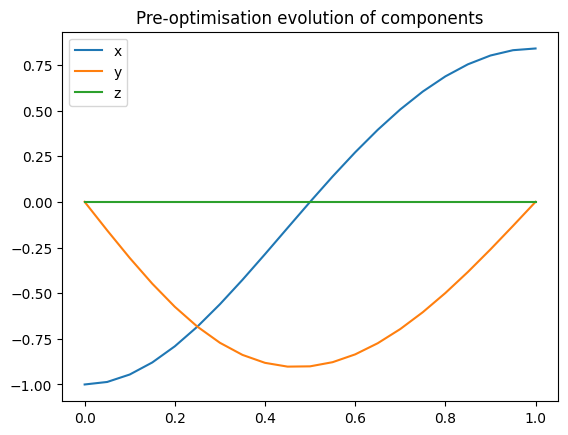

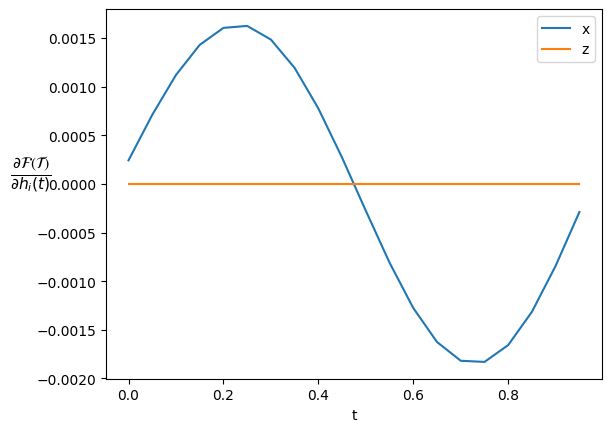

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


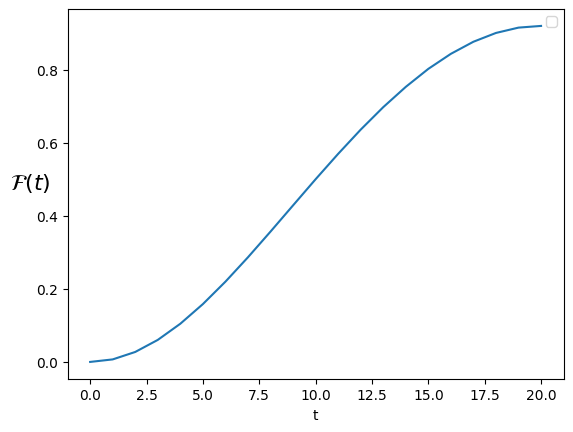

In [49]:
from scipy.linalg import sqrtm


# --- Fidelity Gradient results ------

print(f"the fidelity is {fidelity_dict['fidelity']}")
print(f"the fidelity gradient is {fidelity_dict['gradient']}")

# ----------- Initial Dynamics on Bloch sphere -------------
t, s_x = fidelity_dict['dynamics'].expectations(op.sigma("x"))
t, s_y = fidelity_dict['dynamics'].expectations(op.sigma("y"))
t, s_z = fidelity_dict['dynamics'].expectations(op.sigma("z"))

plt.title("Pre-optimisation evolution of components")

plt.plot(t,s_x,label='x')
plt.plot(t,s_y,label='y')
plt.plot(t,s_z,label='z')

plt.legend()
plt.show()

# ----- Fidelity Gradient Graph --------

def sum_adjacent_elements(list:List)->List:

    half_the_size = len(list) / 2
    assert (half_the_size).is_integer(), \
        'if one output from both pre and post node is given, result must be even'
    half_the_size = int(half_the_size)

    summed_array = np.reshape(list,(half_the_size,2)).sum(axis=1)
    return summed_array


final_derivs_x = sum_adjacent_elements(total_derivs_x)
final_derivs_z = sum_adjacent_elements(total_derivs_z)


plt.plot(t[:-1],final_derivs_x,label='x')
plt.plot(t[:-1],final_derivs_z,label='z')

plt.legend()
plt.ylabel(r"$\frac{\partial \mathcal{F(T)}}{\partial h_i (t)}$",rotation=0,fontsize=16)
plt.xlabel("t")
plt.show()

# Fidelity Graph 
dynamics = fidelity_dict['dynamics']
fidelity=[]

for state in dynamics.states:
    sqrt_final_state = sqrtm(state)
    intermediate_1 = sqrt_final_state @ target_state
    inside_of_sqrt = intermediate_1 @ sqrt_final_state
    fidelity.append((sqrtm(inside_of_sqrt).trace())**2)

plt.plot(fidelity)
plt.ylabel(r"$\mathcal{F} (t)$",rotation=0,fontsize=16)
plt.xlabel("t")

plt.legend()
plt.show()


In [50]:

# ----------- Optimisation of control parameters w.r.t. infidelity ---------------

def flatten_list(parameter_list):
    assert np.shape(parameter_list) == (2*process_tensor.__len__(),num_params)
    parameter_list_flat = [
    x
    for xs in parameter_list
    for x in xs
    ]
    print(np.shape(parameter_list_flat))
    return parameter_list_flat

def unflatten_list(flat_list):
    assert np.shape(flat_list) == (2*num_params*process_tensor.__len__(),)
    parameter_list = np.reshape(flat_list,(2*process_tensor.__len__(),num_params))
    return parameter_list

def sum_adjacent_elements(list:List)->List:
    # maybe this goes in helpers.py or utils.py?
    half_the_size = len(list) / 2
    assert (half_the_size).is_integer(), \
        'if one output from both pre and post node is given, result must be even'
    half_the_size = int(half_the_size)

    # https://stackoverflow.com/a/29392016
    summed_array = np.reshape(list,(half_the_size,2)).sum(axis=1)
    return summed_array

def infidelity(parameter_list_flat):

    parameter_list_var = unflatten_list(parameter_list_flat)

    return_dict = state_gradient(system=parametrized_system,
        initial_state=initial_state,
        target_state=target_state,
        process_tensor=process_tensor,
        parameters=parameter_list_var,
        return_fidelity=True,
        return_dynamics=False)
    
    return -float(return_dict['fidelity'].real)

def fidelity_jacobian(parameter_list_flat):

    parameter_list_var = unflatten_list(parameter_list_flat)

    fidelity_dict = state_gradient(
        system=parametrized_system,
        initial_state=initial_state,
        target_state=target_state,
        process_tensor=process_tensor,
        parameters=parameter_list_var)
    
    fidelity_jacobian = flatten_list(fidelity_dict['gradient'])

    #fidelity_jacobian = sum_adjacent_elements(fidelity_jacobian)

    #piecewiseconst_jacobian = [0]*num_steps*2*num_params

    #for i,element in enumerate(fidelity_jacobian):
        #piecewiseconst_jacobian[2*i] = fidelity_jacobian[i]
        #piecewiseconst_jacobian[2*i+1] = fidelity_jacobian[i]

    fort_jac =np.asfortranarray(fidelity_jacobian)

    return -fort_jac.real

In [51]:
x_bound = [-5*np.pi,5*np.pi]
z_bound = [-np.pi,np.pi]
bounds = np.zeros((2*num_steps*num_params,2))

for i in range(0, 2*num_params*num_steps,2):
        bounds[i] = x_bound
        bounds[i+1] = z_bound

optimization_result = minimize(
                        fun=infidelity,
                        x0=flatten_list(parameter_list),
                        method='L-BFGS-B',
                        jac=fidelity_jacobian,
                        bounds=bounds,
                        callback=infidelity,
                        options = {'disp':True}
)



(80,)
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.1s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.1s
(80,)
--> Compute dynamics:
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           80     M =           10

At X0        40 variables are exactly at the bounds

At iterate    0    f= -9.19898D-01    |proj g|=  9.66588D-04
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.1s
--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.1s
(80,)
--> Compute dynamics:

At iterate    1    f= -9.19913D-01    |proj g|=  9.66495D-04
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.1s
--> Compute dynamics:  ys=-7.622E-10  -gs= 1.542E-05 BFGS update SKIPPED

100.0%   20 of   20 [###############################


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   80      5     36     36     4    31   9.659D-04  -9.204D-01
  F = -0.92039650686704388     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


The maximal fidelity was found to be :  0.9203965068670439
The jacobian was found to be :  [-2.42886711e-04 -1.44789400e-08 -1.15693407e-07 -1.45415293e-08
 -4.71527708e-04 -2.07819993e-08 -2.40113374e-04 -1.61990947e-08
 -6.62474022e-04 -5.48014877e-08 -4.59876060e-04 -3.29617736e-08
 -7.95561229e-04 -1.45431368e-07 -6.36716624e-04 -9.13612920e-08
 -8.56137668e-04 -3.14888393e-07 -7.51665932e-04 -2.18885065e-07
 -8.36551359e-04 -5.64841972e-07 -7.91695637e-04 -4.29146769e-07
 -7.36895518e-04 -8.68791842e-07 -7.51042160e-04 -7.10422950e-07
 -5.64975536e-04 -1.17439091e-06 -6.31769130e-04 -1.02263861e-06
 -3.35807111e-04 -1.41584347e-06 -4.43561027e-04 -1.30484184e-06
 -7.04499496e-05 -1.53282990e-06 -2.03043006e-04 -1.49142911e-06
  2.05717523e-04 -1.48972762e-06  6.75425736e-05 -1.53207285e-06
  4.65196694e-04 -1.28829135e-06  3.42186658e-04 -1.40852161e-06
  6.80935573e-04 -9.68767943e-07  5.93401496e-04 -1.14203986e-06
  8.29262712e-04 -5.98198503e-07  7.94819725e-04 -7.88127574e-07

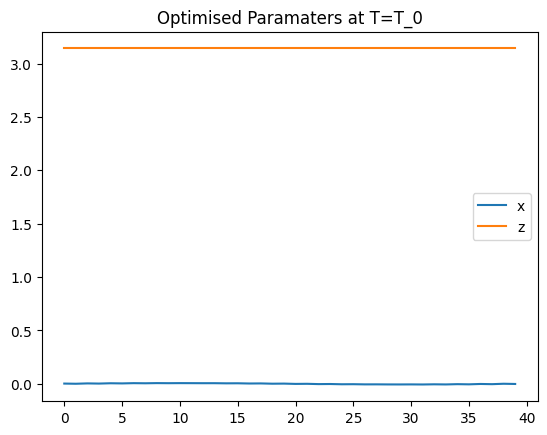

--> Compute dynamics:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.2s
21
the fidelity is (0.9203965068670439-1.6524210325463313e-13j)
the fidelity gradient is [[ 2.42886711e-04+4.77929870e-17j  1.44789400e-08+1.78309922e-15j]
 [ 1.15693407e-07-4.48038062e-19j  1.45415293e-08+1.78308567e-15j]
 [ 4.71527708e-04+2.38846350e-16j  2.07819993e-08+1.78394625e-15j]
 [ 2.40113374e-04+1.40885296e-16j  1.61990947e-08+1.78222508e-15j]
 [ 6.62474022e-04+2.60689636e-16j  5.48014877e-08+1.78297047e-15j]
 [ 4.59876060e-04+2.84443828e-16j  3.29617736e-08+1.78213022e-15j]
 [ 7.95561229e-04+3.21587917e-16j  1.45431368e-07+1.77960267e-15j]
 [ 6.36716624e-04+3.26720937e-16j  9.13612920e-08+1.78049036e-15j]
 [ 8.56137668e-04+3.09756561e-16j  3.14888393e-07+1.78206923e-15j]
 [ 7.51665932e-04+3.61954119e-16j  2.18885065e-07+1.78207601e-15j]
 [ 8.36551359e-04+3.72857127e-16j  5.64841972e-07+1.78288238e-15j]
 [ 7.91695637e-04+3.64535875e-16j  4.29146769e-07+1.78464421e

/Users/eoinoneill/Desktop/PhD/Eoin_B_Oqupy_V2/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/eoinoneill/Desktop/PhD/Eoin_B_Oqupy_V2/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


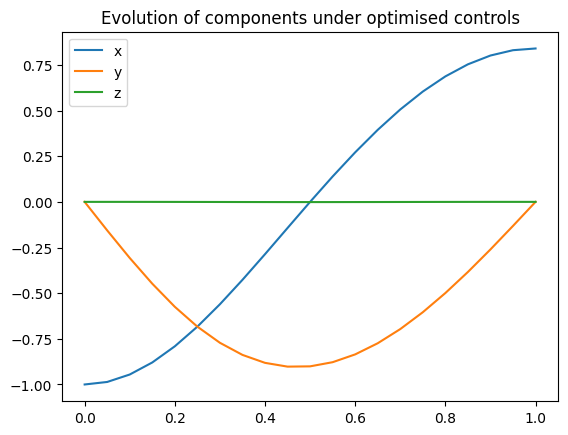

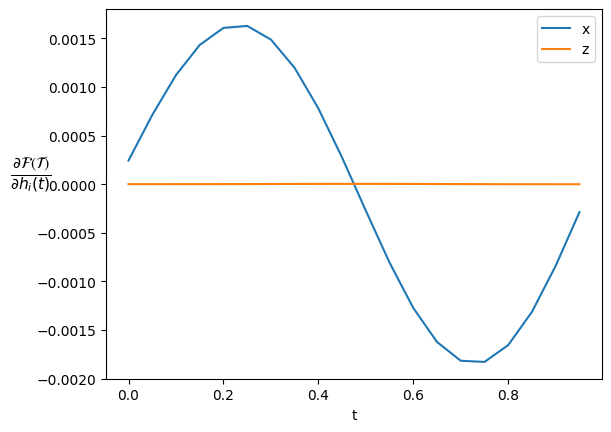

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


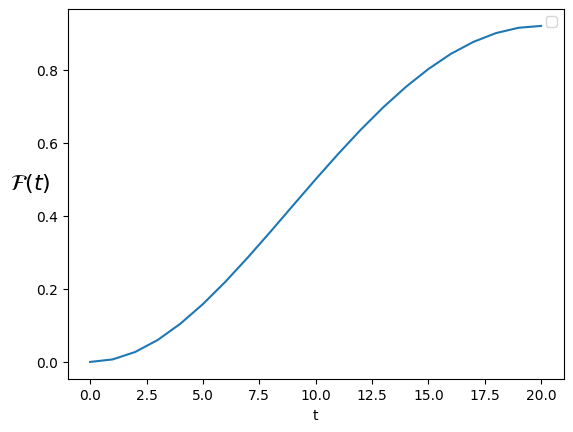

In [52]:

print("The maximal fidelity was found to be : ",-optimization_result.fun)

print("The jacobian was found to be : ",optimization_result.jac)

optimized_parameters_flat = optimization_result.x

times = np.arange(0,2*num_steps)
optimized_parameters = unflatten_list(optimized_parameters_flat)

plt.title("Optimised Paramaters at T=T_0")

opt_params_x = np.array([parameter[0] for parameter in optimized_parameters])
opt_params_z = np.array([parameter[1] for parameter in optimized_parameters])

plt.plot(times,opt_params_x,label='x')
plt.plot(times,opt_params_z,label='z')

plt.legend()
plt.show()

optimized_dynamics = state_gradient(
        system=parametrized_system,
        initial_state=initial_state,
        target_state=target_state,
        process_tensor=process_tensor,
        parameters=optimized_parameters,
        return_fidelity=True,
        return_dynamics=True)

# --- Optimised Fidelity Gradient results ------

print(f"the fidelity is {optimized_dynamics['fidelity']}")
print(f"the fidelity gradient is {optimized_dynamics['gradient']}")

# ----------- Optimised Dynamics on Bloch sphere -------------
t, s_x = optimized_dynamics['dynamics'].expectations(op.sigma("x"))
t, s_y = optimized_dynamics['dynamics'].expectations(op.sigma("y"))
t, s_z = optimized_dynamics['dynamics'].expectations(op.sigma("z"))

plt.title("Evolution of components under optimised controls")

plt.plot(t,s_x,label='x')
plt.plot(t,s_y,label='y')
plt.plot(t,s_z,label='z')

plt.legend()
plt.show()

# ----- Fidelity Gradient Graph --------

opt_derivs_x = np.array([parameter[0] for parameter in optimized_dynamics['gradient']])
opt_derivs_z = np.array([parameter[1] for parameter in optimized_dynamics['gradient']])


final_opt_derivs_x = sum_adjacent_elements(opt_derivs_x)
final_opt_derivs_z = sum_adjacent_elements(opt_derivs_z)


plt.plot(t[:-1],final_opt_derivs_x,label='x')
plt.plot(t[:-1],final_opt_derivs_z,label='z')

plt.legend()
plt.ylabel(r"$\frac{\partial \mathcal{F(T)}}{\partial h_i (t)}$",rotation=0,fontsize=16)
plt.xlabel("t")
plt.show()

# Optimised Fidelity Graph 
dynamics = optimized_dynamics['dynamics']
fidelity=[]

for state in dynamics.states:
    sqrt_final_state = sqrtm(state)
    intermediate_1 = sqrt_final_state @ target_state
    inside_of_sqrt = intermediate_1 @ sqrt_final_state
    fidelity.append((sqrtm(inside_of_sqrt).trace())**2)

plt.plot(fidelity)
plt.ylabel(r"$\mathcal{F} (t)$",rotation=0,fontsize=16)
plt.xlabel("t")

plt.legend()
plt.show()
